In [1]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
#here we are downloading the historical data(10y in this case)
# Define tickers(tickers are unique symbol of companies, like Linade has LNDE)
tickers = ['AAPL', 'MS', 'GOOGL', 'AMZN', 'PYPL', 'GS', 'JPM']

# Download data from Yahoo Finance(yfinance will get data from yahoo which is financial data) 
data = yf.download(tickers, start='2014-01-01', end='2024-01-01')['Adj Close']

# Show the first few rows of the data(head shows the first few rows of the data)
data.head()


[*********************100%%**********************]  7 of 7 completed


Ticker,AAPL,AMZN,GOOGL,GS,JPM,MS,PYPL
Date,,,,,,,
2014-01-02,17.253256,19.898500,27.823923,144.863434,43.550617,23.592047,NaN
2014-01-03,16.874279,19.822001,27.620953,145.895309,43.887287,23.956995,NaN
2014-01-06,16.966295,19.681499,27.928907,146.894440,44.141663,24.040623,NaN
2014-01-07,16.844957,19.901501,28.467329,146.009933,43.632923,23.964590,NaN
2014-01-08,16.951632,20.096001,28.526569,146.132767,44.044395,23.995005,NaN


In [3]:
# Calculate the daily percentage change (returns) for each stock
returns = data.pct_change().dropna()

# Show the first few rows of the returns
returns.head()


Ticker,AAPL,AMZN,GOOGL,GS,JPM,MS,PYPL
Date,,,,,,,
2015-07-07,-0.002460,0.001560,0.008083,0.000817,-0.007872,-0.005920,-0.002452
2015-07-08,-0.024823,-0.016074,-0.015145,-0.019932,-0.020509,-0.021492,-0.052430
2015-07-09,-0.020397,0.010915,0.005446,0.003675,0.010393,0.008203,-0.005764
2015-07-10,0.026734,0.020995,0.021041,0.011620,0.014219,0.014174,0.005507
2015-07-13,0.019306,0.027192,0.028088,0.014142,0.015510,0.017598,0.060248


In [4]:
# Calculate the mean daily return for each stock
mean_returns = returns.mean()

# Calculate the annualized mean return (252 bcz there are 252 trading days on avg in a year)
annual_mean_returns = mean_returns * 252

# Calculate the covariance matrix for the asset returns
cov_matrix = returns.cov() * 252  # Annualize the covariance matrix


In [5]:
# Number of portfolios to simulate
num_portfolios = 10000

# Arrays to store portfolio results
portfolio_returns = []
portfolio_volatility = []
sharpe_ratios = []
portfolio_weights = []

# Generate random portfolios
for _ in range(num_portfolios):
    # Generate random weights and normalize them
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Calculate the expected portfolio return
    portfolio_return = np.sum(weights * annual_mean_returns)
    
    # Calculate portfolio volatility (standard deviation)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Calculate the Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = portfolio_return / portfolio_stddev
    
    # Append results
    portfolio_returns.append(portfolio_return)
    portfolio_volatility.append(portfolio_stddev)
    sharpe_ratios.append(sharpe_ratio)
    portfolio_weights.append(weights)

# Convert lists into NumPy arrays
portfolio_returns = np.array(portfolio_returns)
portfolio_volatility = np.array(portfolio_volatility)
sharpe_ratios = np.array(sharpe_ratios)
portfolio_weights = np.array(portfolio_weights)


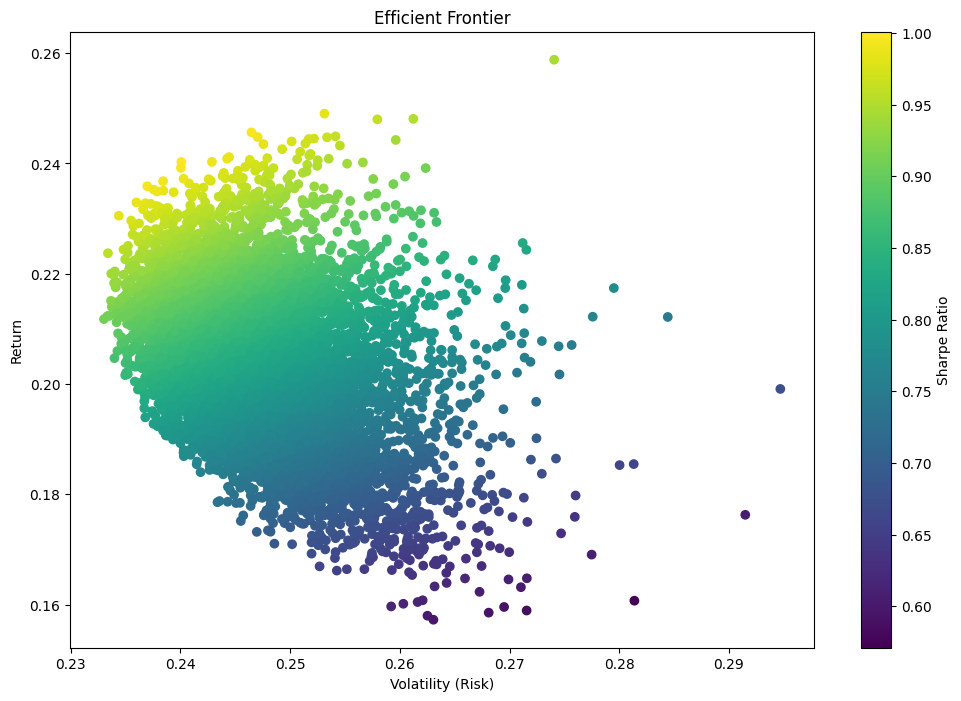

In [6]:
# Plot the Efficient Frontier (scatter plot of risk vs return)
plt.figure(figsize=(12,8))
plt.scatter(portfolio_volatility, portfolio_returns, c=sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.show()


In [7]:
# Function to calculate portfolio performance (return and volatility)
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility


In [8]:
# Function to minimize portfolio volatility (risk)
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]


In [9]:
# Constraint: Sum of weights must be equal to 1 (fully invested)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: Weight of each asset must be between 0 and 1
bounds = tuple((0, 1) for asset in range(len(tickers)))

# Initial guess (equal weights)
initial_weights = len(tickers) * [1 / len(tickers)]


In [10]:
# Optimize the portfolio to minimize volatility
optimized_result = minimize(minimize_volatility, initial_weights, args=(annual_mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = optimized_result.x

# Calculate the performance of the optimized portfolio
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, annual_mean_returns, cov_matrix)


In [11]:
# Optimal portfolio details
print("Optimal Portfolio Weights:", optimal_weights)
print("Expected Annual Return:", optimal_return)
print("Expected Annual Volatility:", optimal_volatility)

# Calculate Sharpe Ratio for the optimized portfolio
risk_free_rate = 0.01  # Assume a risk-free rate of 1%
sharpe_ratio_optimal = (optimal_return - risk_free_rate) / optimal_volatility
print("Optimal Portfolio Sharpe Ratio:", sharpe_ratio_optimal)


Optimal Portfolio Weights: [2.00427685e-01 1.40468601e-01 2.22305509e-01 3.24399462e-02
 4.04358259e-01 6.83047369e-18 5.24482801e-18]
Expected Annual Return: 0.2216427069269182
Expected Annual Volatility: 0.23162584896856808
Optimal Portfolio Sharpe Ratio: 0.9137266322794498


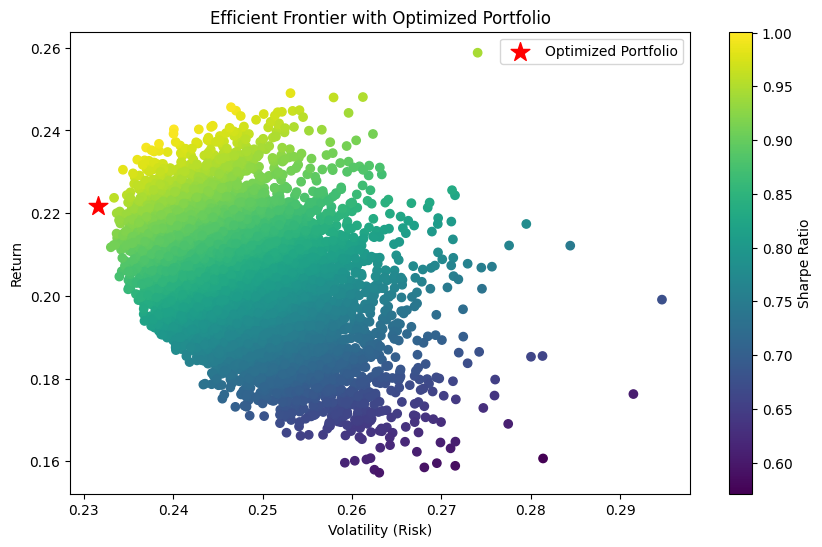

In [12]:
# Plot the Efficient Frontier with the optimized portfolio
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatility, portfolio_returns, c=sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=200, label='Optimized Portfolio')
plt.title('Efficient Frontier with Optimized Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.show()